# Multi-label text classification using BERT

In [7]:
#
# original source
# https://github.com/dtolk/multilabel-BERT/blob/master/notebooks/multi_label_text_classification_BERT.ipynb
# 
#  

import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

BATCH_SIZE = 32

MAX_LENGTH = 512  # Max sequence length for the transformer models

TEST_SIZE = 0.3
VAL_SIZE = 0.3

DATASET_DIR = "../datasets"
VECTOR_CACHE = "../.vector_cache"

RANDOM_SEED = 42

# Check device
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("MPS is available")
        return torch.device("mps")
    else:
        print("Using CPU")
        return torch.device("cpu")


device = get_device()
print("device:", device)

MPS is available
device: mps


In [8]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def _label_matrix(tr_target, te_target):
    """
    Converts multi-label target data into a binary matrix format using MultiLabelBinarizer.
    
    Input:
    - tr_target: A list (or iterable) of multi-label sets for the training data. 
                 Each element is a list, tuple, or set of labels assigned to a sample.
                 Example: [["label1", "label2"], ["label3"], ["label2", "label4"]]
    - te_target: A list (or iterable) of multi-label sets for the test data.
                 Each element is a list, tuple, or set of labels assigned to a sample.
                 Example: [["label1"], ["label3", "label4"]]
    
    Output:
    - ytr: A binary label matrix for the training data where each column represents a label.
           The matrix has shape (n_samples, n_classes).
    - yte: A binary label matrix for the test data where each column represents a label.
           The matrix has shape (n_samples, n_classes).
    - mlb.classes_: A list of all unique classes (labels) across the training data.
    """
    
    """
    print("_label_matrix...")
    print("tr_target:", tr_target)
    print("te_target:", te_target)
    """

    mlb = MultiLabelBinarizer(sparse_output=True)
    
    ytr = mlb.fit_transform(tr_target)
    yte = mlb.transform(te_target)

    """
    print("ytr:", type(ytr), ytr.shape)
    print("yte:", type(yte), yte.shape)

    print("MultiLabelBinarizer.classes_:\n", mlb.classes_)
    """
    
    return ytr, yte, mlb.classes_


In [9]:
from data.reuters21578_reader import fetch_reuters21578

def load_reuters21578():

    data_path = os.path.join(DATASET_DIR, 'reuters21578')    
    print("data_path:", data_path)  

    train_labelled_docs = fetch_reuters21578(subset='train', data_path=data_path)
    test_labelled_doc = fetch_reuters21578(subset='test', data_path=data_path)

    train_data = train_labelled_docs.data
    train_target = train_labelled_docs.target
    test_data = test_labelled_doc.data
    test_target = test_labelled_doc.target

    class_type = 'multi-label'

    train_target, test_target, target_names = _label_matrix(train_target, test_target)

    train_target = train_target.toarray()                                     # Convert to dense
    test_target = test_target.toarray()                                       # Convert to dense

    target_names = train_labelled_docs.target_names
    num_classes = len(target_names)
    print(f"num_classes: {len(target_names)}")
    print("class_names:", target_names)

    return (train_data, train_target), (test_data, test_target), num_classes, target_names, class_type

In [10]:
"""
data_dir = "/content/drive/MyDrive/Notebooks_BERT/data"
df_data = pd.read_csv(os.path.join(data_dir,"input","arxiv-preproc-data.tsv"), sep="\t")
"""

# Load dataset and print class information
(train_data, train_target), (test_data, test_target), num_classes, target_names, class_type = load_reuters21578()

print("num_classes:", num_classes)
print("target_names:", target_names)

print("train_data:", type(train_data), len(train_data))
print("train_data[0]:", type(train_data[0]), train_data[0])
print("train_target:", type(train_target), len(train_target))
print("train_target[0]:", type(train_target[0]), train_target[0].shape, train_target[0])

print("test_data:", type(test_data), len(test_data))
print("test_data[0]:", type(test_data[0]), test_data[0])
print("test_target:", type(test_target), len(test_target))
print("test_target[0]:", type(test_target[0]), test_target[0].shape, test_target[0])

data_path: ../datasets/reuters21578
num_classes: 115
class_names: ['acq', 'alum', 'austdlr', 'barley', 'bop', 'can', 'carcass', 'castor-oil', 'castorseed', 'citruspulp', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'corn-oil', 'cornglutenfeed', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'cruzado', 'dfl', 'dkr', 'dlr', 'dmk', 'earn', 'fishmeal', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'inventories', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-meal', 'lin-oil', 'linseed', 'lit', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'peseta', 'pet-chem', 'platinum', 'plywood', 'pork-belly', 'potato', 'propane', 'rand', 'rape-meal', 'rape-oil', 'rapeseed', 'red-bean', 'reserves', 'retail', 'rice', 'ringgit', 'rubber',

In [13]:
train_data

('INCO SEES NO MAJOR IMPACT FROM DOW REMOVAL\nInco Ltd said it did not expect its earlier reported removal from the Dow Jones industrial index to make a major impact on the company\'s stock. "We don\'t think that individuals or institutions buy our shares because we were one of the Dow Jones industrials," spokesman Ken Cherney said in reply to a query. Inco closed 1-3/8 lower at 19-3/8 in second most active trading on the Toronto Stock Exchange. The Wall Street Journal, which selects the index, said Inco was dropped to make the index more representative of the market. Inco, the non-Communist world\'s largest nickel producer, was a member of the index since 1928. Replacing Inco and Owens-Illinois Inc will be Coca-Cola Co and Boeing Co, effective tomorrow. Nickel analyst Ilmar Martens at Walwyn Stodgell Cochran Murray Ltd said Inco\'s removal from the index would likely spark short-term selling pressure on the stock. "Some investors who have Inco may suddenly say, \'well, because it\'s n

In [14]:
# Convert the tuple to a DataFrame with each element in a separate row
df_train_data = pd.DataFrame(train_data, columns=["text"])
df_test_data = pd.DataFrame(test_data, columns=["text"])

# Display the DataFrame
print(df_train_data.head())
print(df_test_data.head())

                                                text
0  INCO SEES NO MAJOR IMPACT FROM DOW REMOVAL\nIn...
1  FORMER EMPIRE OF CAROLINA <EMP> EXEC SENTENCED...
2  U.S. ECONOMIC DATA KEY TO DEBT FUTURES OUTLOOK...
3  UNUSUAL TEXAS INSTRUMENTS <TXN> PREFERRED PRIC...
4  FORD MOTOR <F> DISTRIBUTES PROFIT SHARING\nFor...
                                                text
0  HOSPITAL CORP SAYS IT RECEIVED 47 DLR A SHARE ...
1  BEVERLY ENTERPRISES <BEV> SETS REGULAR DIVIDEN...
2  TREASURY'S BAKER SAYS FLOATING EXCHANGE RATE S...
3  CRUDE OIL NETBACKS UP SHARPLY IN EUROPE, U.S.\...
4  TREASURY'S BAKER SAYS SYSTEM NEEDS STABILITY\n...


In [28]:
# Create a DataFrame for the train_target array with columns for each class
target_df = pd.DataFrame(train_target, columns=target_names)

# Concatenate the text data DataFrame with the target DataFrame
df_train_data = pd.concat([df_train_data, target_df], axis=1)

df_train_data.head()

,text,acq,alum,austdlr,barley,bop,can,carcass,castor-oil,castorseed,...,tapioca,tea,tin,trade,veg-oil,wheat,wool,wpi,yen,zinc
6100,IMMUCOR <BLUD> SPLITS STOCK\nImmucor Inc said ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4505,INDONESIA SEES LIMITED CHOICES ON ECONOMY\nInd...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2455,SALOMON RAISES CATERPILLAR <CAT> OPINION\nSalo...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8051,ITT'S <ITT> HARTFORD UNIT POSTS 4TH QTR GAIN\n...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6363,HOVNANIAN ENTERPRISES <HOV> SPLITS STOCK\nHovn...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Create a DataFrame for the train_target array with columns for each class
target_df = pd.DataFrame(test_target, columns=target_names)

# Concatenate the text data DataFrame with the target DataFrame
df_test_data = pd.concat([df_test_data, target_df], axis=1)

df_test_data.head()

,text,acq,alum,austdlr,barley,bop,can,carcass,castor-oil,castorseed,...,tapioca,tea,tin,trade,veg-oil,wheat,wool,wpi,yen,zinc
467,INDEPENDENT BANK CORP <IBCP.O> 1ST QTR NET\nSh...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2657,BURNDY CORP <BDC> 3RD QTR OCT 2 NET\nShr 21 ct...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
98,BOND CORP TO ACQUIRE 80 PCT OF MERLIN PETE\nBo...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2143,U.S. ENERGY SECRETARY SEES HIGHER OIL PRICES\n...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3143,AMERICAN REPUBLIC BANCORP <ARBC.O> 3RD QTR NET...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Subsample the data
#df_data = df_data.sample(n = 10_000, random_state = 4)
#df_data.head()

In [30]:
from sklearn.model_selection import train_test_split

"""
# Combine title and abstract to increase power
df_data["combined"] = df_data["title"] + ". " + df_data["abstract"]
df_data.drop(columns=["abstract", "title"], axis=1, inplace=True)


# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)

# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)
"""

# split test into test and validation datasets
#df_test_data, df_valid_data = train_test_split(df_test_data, random_state=88, test_size=0.50, shuffle=True)
df_train_data, df_valid_data = train_test_split(df_train_data, random_state=88, test_size=0.15, shuffle=True)

In [31]:
df_train_data.head()

,text,acq,alum,austdlr,barley,bop,can,carcass,castor-oil,castorseed,...,tapioca,tea,tin,trade,veg-oil,wheat,wool,wpi,yen,zinc
7484,MANUFACTURERS <MHC> IN BUILDING FORECLOSURE\nM...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7299,WTC INTERNATIONAL <WAF> SETS SOUTH AFRICA TRUS...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8490,AUDITORS LIFT QUALIFICATION ON BRUNSWICK <BC>\...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1568,INTERLINK SAYS NOT PLANNING BID FOR PUROLATOR\...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7555,ESQUIRE RADIO AND ELECTRONICS INC <EE> 4TH QTR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
print(f"Train: {df_train_data.shape}, Test: {df_test_data.shape}, Valid: {df_valid_data.shape}")

Train: (8162, 346), Test: (3299, 346), Valid: (1441, 346)


In [11]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [13]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=VECTOR_CACHE+'/BERT')

In [14]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."

# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")

# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
print("encoded input_ids:\n", encodings['input_ids'])
print("encoded attention_mask:\n", encodings['attention_mask'])
print("encoded token_type_ids:\n", encodings['token_type_ids'])

encoded input_ids:
 tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
encoded attention_mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])
encoded token_type_ids:
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [15]:
#df_train['combined']

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [17]:
target_list = target_names
#target_list = list(df_data.columns)
target_list

['acq',
 'alum',
 'austdlr',
 'barley',
 'bop',
 'can',
 'carcass',
 'castor-oil',
 'castorseed',
 'citruspulp',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'corn-oil',
 'cornglutenfeed',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'cruzado',
 'dfl',
 'dkr',
 'dlr',
 'dmk',
 'earn',
 'fishmeal',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'inventories',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-meal',
 'lin-oil',
 'linseed',
 'lit',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'peseta',
 'pet-chem',
 'platinum',
 'plywood',
 'pork-belly',
 'potato',
 'propane',
 'rand',
 'rape-meal',
 'rape-oil',
 'rapeseed',
 'red-bean',
 'reserves',
 'retail',
 'rice',


In [28]:
target_list = target_list[:-1]
target_list

['acq',
 'alum',
 'austdlr',
 'barley',
 'bop',
 'can',
 'carcass',
 'castor-oil',
 'castorseed',
 'citruspulp',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'corn-oil',
 'cornglutenfeed',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'cruzado',
 'dfl',
 'dkr',
 'dlr',
 'dmk',
 'earn',
 'fishmeal',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'inventories',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-meal',
 'lin-oil',
 'linseed',
 'lit',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'peseta',
 'pet-chem',
 'platinum',
 'plywood',
 'pork-belly',
 'potato',
 'propane',
 'rand',
 'rape-meal',
 'rape-oil',
 'rapeseed',
 'red-bean',
 'reserves',
 'retail',
 'rice',


In [18]:
train_dataset = CustomDataset(df_train_data, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid_data, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test_data, tokenizer, MAX_LEN, target_list)

In [19]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101,  4297,  2080,  5927,  2053,  2350,  4254,  2013, 23268,  8208,
          4297,  2080,  5183,  2056,  2009,  2106,  2025,  5987,  2049,  3041,
          2988,  8208,  2013,  1996, 23268,  3557,  3919,  5950,  2000,  2191,
          1037,  2350,  4254,  2006,  1996,  2194,  1005,  1055,  4518,  1012,
          1000,  2057,  2123,  1005,  1056,  2228,  2008,  3633,  2030,  4896,
          4965,  2256,  6661,  2138,  2057,  2020,  2028,  1997,  1996, 23268,
          3557,  3919,  2015,  1010,  1000, 14056,  6358, 24188,  5420,  2056,
          1999,  7514,  2000,  1037, 23032,  1012,  4297,  2080,  2701,  1015,
          1011,  1017,  1013,  1022,  2896,  2012,  2539,  1011,  1017,  1013,
          1022,  1999,  2117,  2087,  3161,  6202,  2006,  1996,  4361,  4518,
          3863,  1012,  1996,  2813,  2395,  3485,  1010,  2029, 27034,  1996,
          5950,  1010,  2056,  4297,  2080,  2001,  3333,  2000,  2191,  1996,
          5950,  2062,  4387,  1997,  1

In [20]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [21]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [22]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# This version is more numerically stable than using a plain Sigmoid followed 
# by a BCELoss as, by combining the operations into one layer, 
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [23]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         

/opt/anaconda3/envs/python312/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [25]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

## Model Training

In [28]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join('../out/',"MLTC_model_state.bin"))
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0597, val_loss=0.0516 train_acc=0.9913, val_acc=0.9902
Epoch 2/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0469, val_loss=0.0446 train_acc=0.9912, val_acc=0.9902
Epoch 3/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0414, val_loss=0.0408 train_acc=0.9913, val_acc=0.9902
Epoch 4/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0374, val_loss=0.0367 train_acc=0.9920, val_acc=0.9923
Epoch 5/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0331, val_loss=0.0321 train_acc=0.9933, val_acc=0.9929
Epoch 6/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0293, val_loss=0.0286 train_acc=0.9940, val_acc=0.9946
Epoch 7/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0260, val_loss=0.0256 train_acc=0.9949, val_acc=0.9949
Epoch 8/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0233, val_loss=0.0233 train_acc=0.9954, val_acc=0.9951
Epoch 9/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0212, val_loss=0.0216 train_acc=0.9957, val_acc=0.9954
Epoch 10/10


  0%|          | 0/301 [00:00<?, ?it/s]

train_loss=0.0193, val_loss=0.0198 train_acc=0.9960, val_acc=0.9954


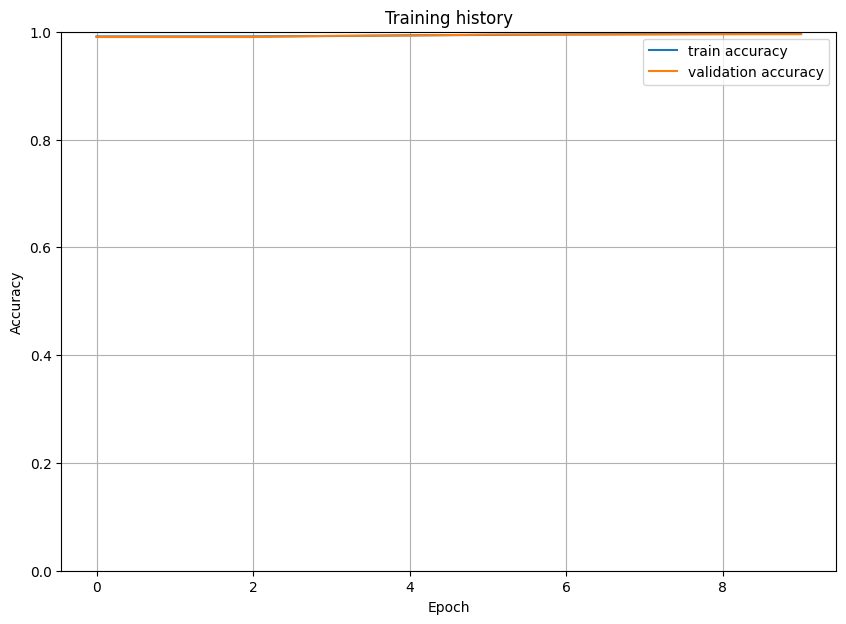

In [29]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Evaluation of the model

In [30]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join('../out/',"MLTC_model_state.bin")))
model = model.to(device)

/var/folders/2f/8yk84n2d0lq3j_x4rd8w0b380000gn/T/ipykernel_12716/1324315399.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join

In [1]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

NameError: name 'eval_model' is not defined

In [32]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.9954386057426108

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values


In [35]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [36]:
# sanity check
predictions.numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [37]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:1649 
predictions:torch.Size([1649, 115]) 
prediction_probs:torch.Size([1649, 115]) 
target_values:torch.Size([1649, 115])


In [38]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list))

                 precision    recall  f1-score   support

            acq       0.98      0.96      0.97       356
           alum       0.00      0.00      0.00        15
        austdlr       0.00      0.00      0.00         0
         barley       0.00      0.00      0.00         6
            bop       0.00      0.00      0.00        16
            can       0.00      0.00      0.00         0
        carcass       0.00      0.00      0.00         7
     castor-oil       0.00      0.00      0.00         1
     castorseed       0.00      0.00      0.00         0
     citruspulp       0.00      0.00      0.00         0
          cocoa       0.00      0.00      0.00         8
        coconut       0.00      0.00      0.00         2
    coconut-oil       0.00      0.00      0.00         1
         coffee       0.00      0.00      0.00        13
         copper       0.00      0.00      0.00        11
     copra-cake       0.00      0.00      0.00         1
           corn       1.00    

/opt/anaconda3/envs/python312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/python312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/python312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(re

In [42]:
# import seaborn as sns
# def show_confusion_matrix(confusion_matrix):
#     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#     plt.ylabel('True category')
#     plt.xlabel('Predicted category');

In [44]:
# cm = confusion_matrix(target_values, predictions)
# df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
# show_confusion_matrix(df_cm)

## Predicting on raw text

In [45]:
# raw text
raw_text = "Measurement of D-meson production as a function of charged-particle multiplicity in proton--proton collisions at s√=13 TeV with ALICE at the LHC."

In [46]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [55]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.5
output = output.flatten().round().numpy()
output

array([0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [59]:
# Correctly identified the topic of the paper: High energy physics
print(f"Title: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")

Title: Measurement of D-meson production as a function of charged-particle multiplicity in proton--proton collisions at s√=13 TeV with ALICE at the LHC.
Label: hep-ph
